#Датасет 

https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci

In [ ]:
DATASET_PATH = 'C:\\Users\\anke\\OneDrive\\Документы\\ML\\heart_kaggle\\heart_cleveland_upload.csv'

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, accuracy_score, recall_score
import scipy.stats as stats
from itertools import combinations, product
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv(DATASET_PATH)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.100,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.800,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.600,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.400,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.800,1,0,0,0


In [ ]:
f'длина: {len(data)}'

'длина: 297'

1.age: age in years 

2.sex: sex (1 = male; 0 = female)

3.cp: chest pain type # Categorical

-- Value 0: typical angina(стенокардия)

-- Value 1: atypical angina

-- Value 2: non-anginal pain

-- Value 3: asymptomatic

4.trestbps: resting blood pressure (in mm Hg on admission to the hospital)

5.chol: serum cholestoral in mg/dl

6.fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

7.restecg: resting electrocardiographic results # Categorical

-- Value 0: normal

-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria


8.thalach: maximum heart rate achieved

9.exang: exercise induced angina (1 = yes; 0 = no)

10.oldpeak = ST depression induced by exercise relative to rest

11.slope: the slope of the peak exercise ST segment # Categorical

-- Value 0: upsloping

-- Value 1: flat

-- Value 2: downsloping

12.ca: number of major vessels (0-3) colored by flourosopy # Ordered

13.thal: A blood disorder called thalassemia # Categorical

0 = normal; 1 = fixed defect; 2 = reversable defect

14.condition: 0 = no disease, 1 = disease

In [ ]:
continious = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
not_continious = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

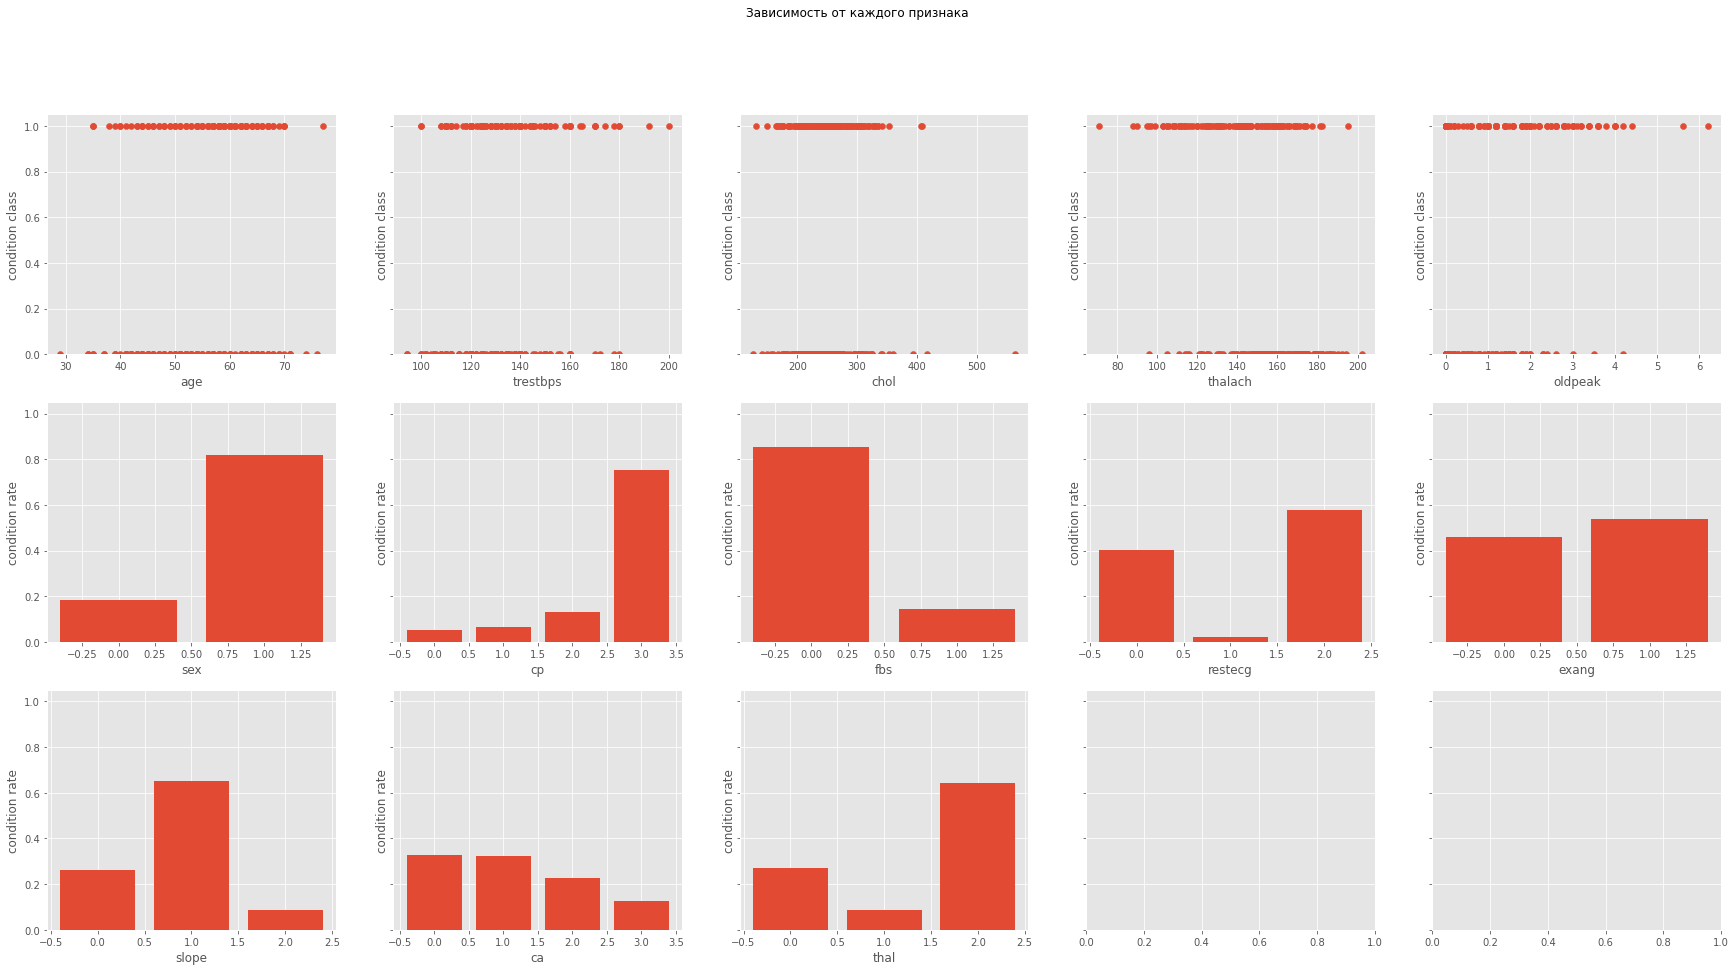

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(30, 15), sharey=True)
for i, col in enumerate(continious):
  axes[0, i].scatter(data[col], data['condition'])
  axes[0, i].set_xlabel(f'{col}')
  axes[0, i].set_ylabel('condition class')
for i, col in enumerate(not_continious):
  all_deseased = data.condition.sum()
  counts = {val: data[data[col]==val]['condition'].sum() / all_deseased for val in data[col].unique()}
  axes[1 + i // 5, i % 5].bar(counts.keys(), counts.values())
  axes[1 + i // 5, i % 5].set_xlabel(f'{col}')
  axes[1 + i // 5, i % 5].set_ylabel('condition rate')
fig.suptitle('Зависимость от каждого признака')
plt.show()

In [ ]:
f"количество мужчин: {data['sex'].sum()}, длина датасета: {len(data)}"  

'количество мужчин: 201, длина датасета: 297'

# корреляции

In [ ]:
cont_and_bin = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex', 'fbs', 'exang', 'condition']
ordinal = ['ca']
categorical = ['cp', 'restecg', 'slope', 'thal']

In [ ]:
correlations_table = pd.DataFrame(columns=data.columns, index=data.columns, dtype=float)

In [ ]:
for col1, col2 in combinations(cont_and_bin, 2):
  corr = np.corrcoef(data[col1], data[col2])[0, 1]
  correlations_table[col1][col2] = corr
  correlations_table[col2][col1] = corr

for col1, col2 in combinations(categorical, 2):
  crosstab = pd.crosstab(data[col1], data[col2])
  pval = stats.chi2_contingency(crosstab)[1]
  correlations_table[col1][col2] = pval
  correlations_table[col2][col1] = pval

for cont, cat in product(cont_and_bin, categorical):
  groups = (np.array(data[data[cat]==val][cont]) for val in data[cat].unique())
  pval = stats.kruskal(*groups).pvalue
  correlations_table[cont][cat] = pval
  correlations_table[cat][cont] = pval

ranked_cat = stats.rankdata(data['ca'], method='average')
for col in cont_and_bin:
  corr = stats.kendalltau(ranked_cat, data[col]).correlation
  correlations_table[col]['ca'] = corr
  correlations_table['ca'][col] = corr 

for col in categorical:
  crosstab = pd.crosstab(ranked_cat, data[col])
  pval = stats.chi2_contingency(crosstab)[1]
  correlations_table[col]['ca'] = pval
  correlations_table['ca'][col] = pval




In [ ]:
correlations_table.style.background_gradient(cmap='Blues')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
age,nan,-0.092399,0.007116,0.290476,0.202644,0.132062,0.023811,-0.394563,0.096489,0.197123,0.005608,0.305668,0.060403,0.227075
sex,-0.092399,nan,0.081719,-0.066340,-0.198089,0.038850,0.156814,-0.060496,0.143581,0.106567,0.687920,0.097321,0.000000,0.278467
cp,0.007116,0.081719,nan,0.054853,0.533596,0.152227,0.171117,0.000000,0.000000,0.000000,0.000209,0.000327,0.000001,0.000000
trestbps,0.290476,-0.066340,0.054853,nan,0.131536,0.180860,0.037536,-0.049108,0.066691,0.191243,0.200041,0.061779,0.085362,0.153490
chol,0.202644,-0.198089,0.533596,0.131536,nan,0.012708,0.018789,-0.000075,0.059339,0.038596,0.729407,0.106884,0.147716,0.080285
fbs,0.132062,0.038850,0.152227,0.180860,0.012708,nan,0.352177,-0.007842,-0.000893,0.008311,0.147311,0.135596,0.184675,0.003167
restecg,0.023811,0.156814,0.171117,0.037536,0.018789,0.352177,nan,0.015157,0.281420,0.011690,0.034943,0.241734,0.521984,0.008467
thalach,-0.394563,-0.060496,0.000000,-0.049108,-0.000075,-0.007842,0.015157,nan,-0.384368,-0.347640,0.000000,-0.224522,0.000000,-0.423817
exang,0.096489,0.143581,0.000000,0.066691,0.059339,-0.000893,0.281420,-0.384368,nan,0.289310,0.000010,0.171783,0.000000,0.421355
oldpeak,0.197123,0.106567,0.000000,0.191243,0.038596,0.008311,0.011690,-0.347640,0.289310,nan,0.000000,0.216070,0.000000,0.424052


#Logit

In [ ]:
def prepro(data, columns=data.columns, norm=True, pca=False, n_comp=10):
  one_hot = set(['cp', 'slope', 'thal', 'restecg']) & set(columns)
  y = data['condition'].copy()
  X = data[columns].copy()
  X.drop(columns=['condition'], inplace=True)
  for col in one_hot:
    dummies = pd.get_dummies(X[col], prefix=f'{col}_')
    X = X.join(dummies)
  X.drop(columns=one_hot, inplace=True)

  if norm:
    to_norm = list(set(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']) & set(columns))
    X[to_norm] = ((X[to_norm] - X[to_norm].mean(axis=0)) / (X[to_norm].var(axis=0))**(1/2))

  if pca:
    Pca = PCA(n_components=n_comp)
    X = Pca.fit_transform(X)

  return train_test_split(X, y, random_state=0, shuffle=True)

In [ ]:
coefficients = pd.DataFrame(index=data.columns)
coefficients['corr'] = correlations_table['condition']
coefficients.drop(index=['condition'], inplace=True)

In [ ]:
def model_pipeline(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  prec = precision_score(y_test, preds)
  accur = accuracy_score(y_test, preds)
  rocauc = roc_auc_score(y_test, preds)
  recall = recall_score(y_test, preds)
  return model, prec, accur, rocauc, recall

In [ ]:
# логрег с l2
X_train, X_test, y_train, y_test = prepro(data)
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
coef = dict(zip(X_train.columns, *logreg.coef_))
coefs = pd.Series(coef, name='l2_full_С1')
coefficients = coefficients.join(coefs, how='outer')
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8947368421052632, accuracy: 0.8533333333333334, recall: 0.8292682926829268, roc auc: 0.8558106169296986


In [ ]:
# логрег с l1
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
coef = dict(zip(X_train.columns, *logreg.coef_))
coefs = pd.Series(coef, name='l1_full_С1')
coefficients = coefficients.join(coefs, how='outer')
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8717948717948718, accuracy: 0.84, recall: 0.8292682926829268, roc auc: 0.8411047345767575


In [ ]:
# удалим скоррелированные признаки, l2
corr_deleted = list(set(data.columns) - set(['age', 'exang', 'chol', 'fbs', 'thalach']))
X_train, X_test, y_train, y_test = prepro(data, corr_deleted)
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
coef = dict(zip(X_train.columns, *logreg.coef_))
coefs = pd.Series(coef, name='l2_corr_deleted_С1')
coefficients = coefficients.join(coefs, how='outer')
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8974358974358975, accuracy: 0.8666666666666667, recall: 0.8536585365853658, roc auc: 0.8680057388809181


In [ ]:
coefficients.style.background_gradient(cmap='Blues')

,corr,l2_full_С1,l1_full_С1,l2_corr_deleted_С1
age,0.227075,-0.039140,0.000000,nan
ca,0.464186,1.017928,0.977203,1.005527
chol,0.080285,0.189894,0.142918,nan
cp,0.000000,nan,nan,nan
cp__0,nan,-0.617585,-0.496693,-0.703934
cp__1,nan,0.077405,0.000000,0.039737
cp__2,nan,-0.722486,-0.723184,-0.754555
cp__3,nan,0.768261,0.722932,1.028318
exang,0.421355,0.507223,0.452898,nan
fbs,0.003167,-0.242005,-0.087544,nan


In [ ]:
# подбор параметра регуляризации улучшений не дает
max_recall = 0
best_c = 1
for c in np.linspace(0.1, 5, 500):
  logreg = LogisticRegression(penalty='l2', solver='liblinear', C=c)
  logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
  if recall > max_recall:
    max_recall = recall
    best_c = c
print(f'max recall: {max_recall}, best c: {best_c}')

max recall: 0.8536585365853658, best c: 0.5320641282565131


Text(0, 0.5, 'explained variance')

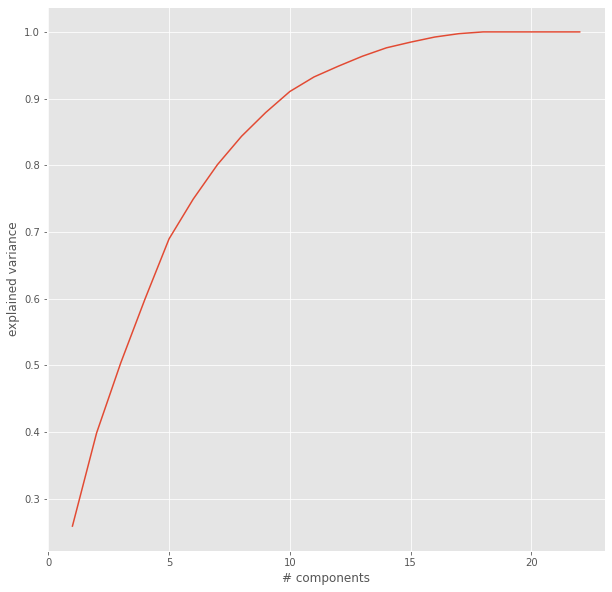

In [ ]:
# PCA explained variance
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
X_train, X_test, y_train, y_test = prepro(data)
pca = PCA()
pca.fit(X_train)
cum_variance = np.cumsum(pca.explained_variance_ratio_)
axis.plot(np.arange(1, cum_variance.shape[0] + 1), cum_variance)
axis.set_xlabel('# components')
axis.set_ylabel('explained variance')


In [ ]:
# pca n=15 + logreg l2
X_train, X_test, y_train, y_test = prepro(data, norm=True, pca=True, n_comp=15)
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8717948717948718, accuracy: 0.84, recall: 0.8292682926829268, roc auc: 0.8411047345767575


In [ ]:
# pca n=15 + удаляем скоррелированные + logreg l2
X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=True, pca=True, n_comp=15)
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8974358974358975, accuracy: 0.8666666666666667, recall: 0.8536585365853658, roc auc: 0.8680057388809181


In [ ]:
max_recall = 0
best_n = 1
for n in np.arange(1, 18):
  X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=True, pca=True, n_comp=n)
  logreg = LogisticRegression(penalty='l2', solver='liblinear')
  logreg, prec, accur, rocauc, recall = model_pipeline(logreg, X_train, X_test, y_train, y_test)
  if recall > max_recall:
    max_recall = recall
    best_n = n
print(f'max recall: {max_recall}, best n: {best_n}')

max recall: 0.8536585365853658, best n: 5


In [ ]:
len(X_test), len(X_train)

(75, 222)

#Деревья

In [ ]:
# на всем датасете
X_train, X_test, y_train, y_test = prepro(data)
tree = DecisionTreeClassifier(random_state=0)
tree, prec, accur, rocauc, recall = model_pipeline(tree, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.75, accuracy: 0.72, recall: 0.7317073170731707, roc auc: 0.7187948350071736


In [ ]:
# удаляем скоррелированные признаки
X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=False)
tree = DecisionTreeClassifier(random_state=0)
tree, prec, accur, rocauc, recall = model_pipeline(tree, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.775, accuracy: 0.7466666666666667, recall: 0.7560975609756098, roc auc: 0.7456958393113343


In [ ]:
# подберем макс глубину и мин количество элементов в листе
X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=False)
max_recall = 0
precision = 0
best_depth = 1
depth_collection = np.arange(2, 100, 1)
leaf_len_collection = np.arange(1, 50, 1)
for depth, leaf in product(depth_collection, leaf_len_collection):
  tree = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=leaf)
  tree, prec, accur, rocauc, recall = model_pipeline(tree, X_train, X_test, y_train, y_test)
  if recall > max_recall:
    max_recall = recall
    precision = prec
    best_depth = depth
    best_leaf_len = leaf
print(f'max recall: {max_recall}, precision: {max_precision}, best depth: {best_depth}, best_leaf_len: {best_leaf_len}')

max recall: 0.7804878048780488, max precision: 0.8888888888888888, best depth: 3, best_leaf_len: 6


[Text(558.0, 951.3000000000001, 'thal__0 <= 0.5\ngini = 0.491\nsamples = 222\nvalue = [126, 96]\nclass = not deseased'),
 Text(279.0, 679.5, 'oldpeak <= 0.7\ngini = 0.364\nsamples = 92\nvalue = [22, 70]\nclass = deseased'),
 Text(139.5, 407.70000000000005, 'ca <= 0.5\ngini = 0.493\nsamples = 25\nvalue = [14, 11]\nclass = not deseased'),
 Text(69.75, 135.89999999999998, 'gini = 0.337\nsamples = 14\nvalue = [11, 3]\nclass = not deseased'),
 Text(209.25, 135.89999999999998, 'gini = 0.397\nsamples = 11\nvalue = [3, 8]\nclass = deseased'),
 Text(418.5, 407.70000000000005, 'cp__0 <= 0.5\ngini = 0.21\nsamples = 67\nvalue = [8, 59]\nclass = deseased'),
 Text(348.75, 135.89999999999998, 'gini = 0.123\nsamples = 61\nvalue = [4, 57]\nclass = deseased'),
 Text(488.25, 135.89999999999998, 'gini = 0.444\nsamples = 6\nvalue = [4, 2]\nclass = not deseased'),
 Text(837.0, 679.5, 'ca <= 0.5\ngini = 0.32\nsamples = 130\nvalue = [104, 26]\nclass = not deseased'),
 Text(697.5, 407.70000000000005, 'trestbps

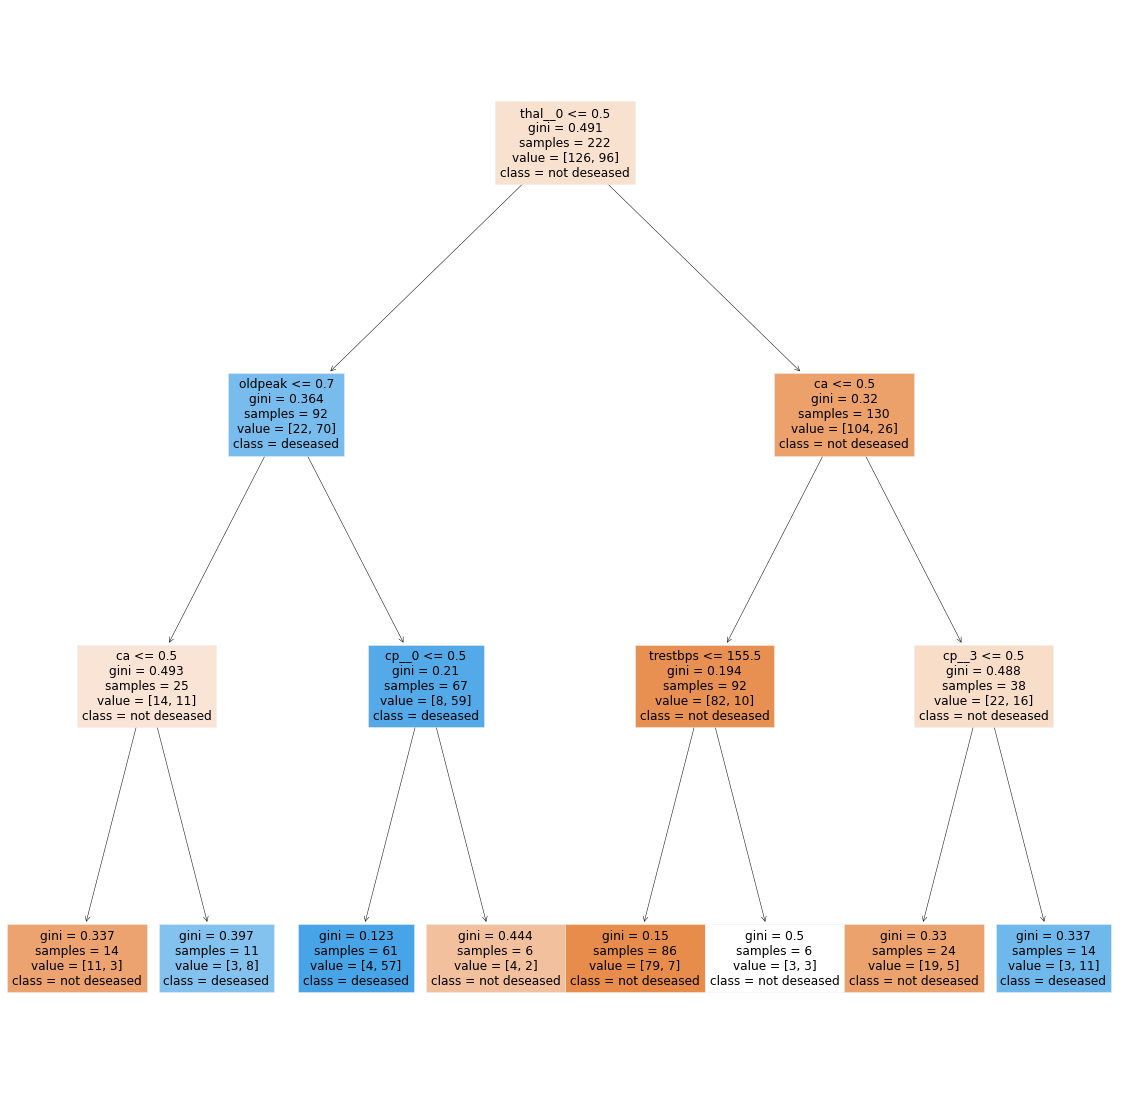

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(20,20))
tree = DecisionTreeClassifier(random_state=0, max_depth=best_depth, min_samples_leaf=best_leaf_len)
tree, prec, accur, rocauc, recall = model_pipeline(tree, X_train, X_test, y_train, y_test)
sklearn.tree.plot_tree(tree, ax=axis, feature_names=X_train.columns, class_names=['not deseased', 'deseased'], filled=True)

In [ ]:
# удаляем скоррелированные признаки + PCA n=5
X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=False, pca=True, n_comp=5)
tree = DecisionTreeClassifier(random_state=0)
tree, prec, accur, rocauc, recall = model_pipeline(tree, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.825, accuracy: 0.8, recall: 0.8048780487804879, roc auc: 0.7994978479196557


In [ ]:
# подберем макс глубину, мин количество элементов в листе и количество компонент
max_recall = 0
best_n = 1
best_depth = 1
best_leaf = 1
depth_collection = np.arange(2, 100)
leaf_collection = np.arange(1, 50)
components_collection = np.arange(1, 18)
for depth, leaf, n in product(depth_collection, leaf_collection, components_collection):
  X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=False, pca=True, n_comp=n)
  tree = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=leaf)
  tree, prec, accur, rocauc, recall = model_pipeline(tree, X_train, X_test, y_train, y_test)
  if recall > max_recall:
    max_recall = recall
    best_depth = depth
    best_leaf = leaf
    best_n = n
print(f'max recall: {max_recall}, best_depth: {best_depth}, best min samples leaf: {best_leaf}, best n: {best_n}')

max recall: 0.8536585365853658, best_depth: 8, best min samples leaf: 1, best n: 7


#Random Forest

In [ ]:
# лес из на полных данных
X_train, X_test, y_train, y_test = prepro(data)
forest = RandomForestClassifier(random_state=0)
forest, prec, accur, rocauc, recall = model_pipeline(forest, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8857142857142857, accuracy: 0.8133333333333334, recall: 0.7560975609756098, roc auc: 0.8192252510760402


In [ ]:
# лес сбез скоррелированных признаков
X_train, X_test, y_train, y_test = prepro(data, corr_deleted)
forest = RandomForestClassifier(random_state=0)
forest, prec, accur, rocauc, recall = model_pipeline(forest, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8648648648648649, accuracy: 0.8133333333333334, recall: 0.7804878048780488, roc auc: 0.8167144906743184


In [ ]:
# лес без скоррелированных признаков с best_depth, best_min_samples_leaf для дерева
X_train, X_test, y_train, y_test = prepro(data, corr_deleted)
forest = RandomForestClassifier(random_state=0, max_depth=3, min_samples_leaf=6)
forest, prec, accur, rocauc, recall = model_pipeline(forest, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.8536585365853658, accuracy: 0.84, recall: 0.8536585365853658, roc auc: 0.8385939741750358


In [ ]:
# подберем макс глубину, мин количество элементов в листе
X_train, X_test, y_train, y_test = prepro(data, corr_deleted, norm=False)
max_recall = 0
precision = 0
best_depth = 1
depth_collection = np.arange(2, 100, 1)
leaf_len_collection = np.arange(1, 50, 1)
for depth, leaf in product(depth_collection, leaf_len_collection):
  forest = RandomForestClassifier(random_state=0, max_depth=depth, min_samples_leaf=leaf)
  forest, prec, accur, rocauc, recall = model_pipeline(forest, X_train, X_test, y_train, y_test)
  if recall > max_recall:
    max_recall = recall
    precision = prec
    best_depth = depth
    best_leaf_len = leaf
print(f'max recall: {max_recall}, precision: {max_precision}, best depth: {best_depth}, best_leaf_len: {best_leaf_len}')

max recall: 0.8780487804878049, precision: 0.8888888888888888, best depth: 5, best_leaf_len: 7


In [ ]:
# подберем макс глубину, мин количество элементов в листе и количество компонент
max_recall = 0
best_n = 1
best_depth = 1
best_leaf = 1
depth_collection = np.arange(2, 20)
leaf_collection = np.arange(1, 20)
components_collection = np.arange(1, 18)
for depth, leaf, n in product(depth_collection, leaf_collection, components_collection):
  X_train, X_test, y_train, y_test = prepro(data, norm=False, pca=True, n_comp=n)
  forest = RandomForestClassifier(random_state=0, max_depth=depth, min_samples_leaf=leaf)
  forest, prec, accur, rocauc, recall = model_pipeline(forest, X_train, X_test, y_train, y_test)
  if recall > max_recall:
    max_recall = recall
    best_depth = depth
    best_leaf = leaf
    best_n = n
print(f'max recall: {max_recall}, best_depth: {best_depth}, best min samples leaf: {best_leaf}, best n: {best_n}')

max recall: 0.9024390243902439, best_depth: 4, best min samples leaf: 11, best n: 12


In [ ]:
X_train, X_test, y_train, y_test = prepro(data, norm=False, pca=True, n_comp=best_n)
forest = RandomForestClassifier(random_state=0, max_depth=best_depth, min_samples_leaf=best_leaf)
forest, prec, accur, rocauc, recall = model_pipeline(forest, X_train, X_test, y_train, y_test)
print(f'precision: {prec}, accuracy: {accur}, recall: {recall}, roc auc: {rocauc}')

precision: 0.9024390243902439, accuracy: 0.8933333333333333, recall: 0.9024390243902439, roc auc: 0.8923959827833572
